# Laptop Prices Prediction
This analysis and model will be used to find correlation between specs and laptop price aswell as being used to predict laptop prices in the future.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor

import os


## Variable Identification
First I will explore each variable first, I want to find out the data type of each and how many null entries I have in the dataset.

In [3]:
laptops = pd.read_csv('./laptop_price.csv',encoding='latin-1')
laptops = laptops.set_index('laptop_ID')
laptops.head()

,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros
laptop_ID,,,,,,,,,,,,
1,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,1339.69
2,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,898.94
3,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,575.00
4,Apple,MacBook Pro,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,2537.45
5,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,1803.60


Wow! Not one missing entry! Don't you love it when this happens.

In [4]:
laptops.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1303 entries, 1 to 1320
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Company           1303 non-null   object 
 1   Product           1303 non-null   object 
 2   TypeName          1303 non-null   object 
 3   Inches            1303 non-null   float64
 4   ScreenResolution  1303 non-null   object 
 5   Cpu               1303 non-null   object 
 6   Ram               1303 non-null   object 
 7   Memory            1303 non-null   object 
 8   Gpu               1303 non-null   object 
 9   OpSys             1303 non-null   object 
 10  Weight            1303 non-null   object 
 11  Price_euros       1303 non-null   float64
dtypes: float64(2), object(10)
memory usage: 132.3+ KB


In [5]:
laptops.describe()

,Inches,Price_euros
count,1303.000000,1303.000000
mean,15.017191,1123.686992
std,1.426304,699.009043
min,10.100000,174.000000
25%,14.000000,599.000000
50%,15.600000,977.000000
75%,15.600000,1487.880000
max,18.400000,6099.000000


## Univariate Analysis
Now I will visualize some features to try and find some outliers and see if we can find some interesting stats.

<AxesSubplot: xlabel='Company', ylabel='count'>

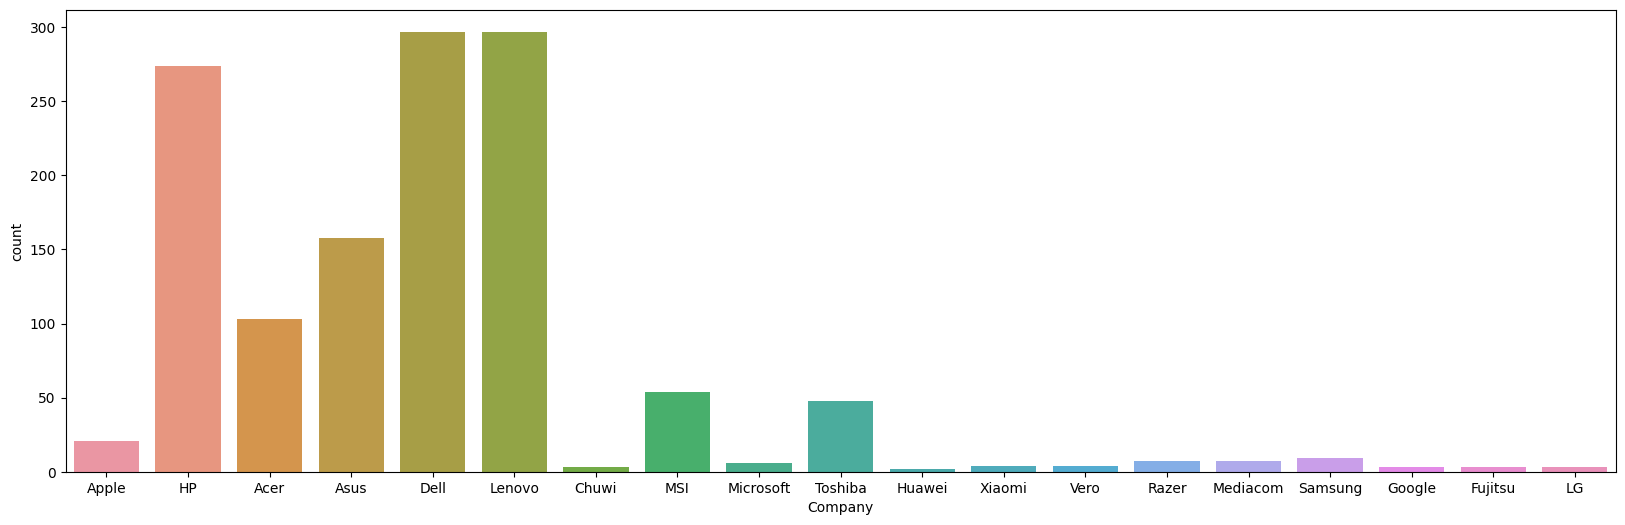

In [6]:
laptops['Company'].value_counts()
fig_dims = (20, 6)
fig, ax = plt.subplots(figsize=fig_dims)
sb.countplot(x="Company", data=laptops, ax=ax)

## Data Cleaning & Prep
Next, I will clean up all of the confusing categorical data

In [7]:
laptops["Ram"] = laptops["Ram"].str.replace('GB', '')
laptops["Weight"] = laptops["Weight"].str.replace('kg', '')
laptops['Memory'] = laptops['Memory'].astype(str).replace('\.0', '', regex=True)
laptops["Memory"] = laptops["Memory"].str.replace('GB', '')
laptops["Memory"] = laptops["Memory"].str.replace('TB', '000')
new2 = laptops["Memory"].str.split("+", n = 1, expand = True)
laptops["first"]= new2[0]
laptops["first"]=laptops["first"].str.strip()
laptops["second"]= new2[1]
laptops["Layer1HDD"] = laptops["first"].apply(lambda x: 1 if "HDD" in x else 0)
laptops["Layer1SSD"] = laptops["first"].apply(lambda x: 1 if "SSD" in x else 0)
laptops["Layer1Hybrid"] = laptops["first"].apply(lambda x: 1 if "Hybrid" in x else 0)
laptops["Layer1Flash_Storage"] = laptops["first"].apply(lambda x: 1 if "Flash Storage" in x else 0)
laptops['first'] = laptops['first'].str.replace(r'\D', '')
laptops["second"].fillna("0", inplace = True)
laptops["Layer2HDD"] = laptops["second"].apply(lambda x: 1 if "HDD" in x else 0)
laptops["Layer2SSD"] = laptops["second"].apply(lambda x: 1 if "SSD" in x else 0)
laptops["Layer2Hybrid"] = laptops["second"].apply(lambda x: 1 if "Hybrid" in x else 0)
laptops["Layer2Flash_Storage"] = laptops["second"].apply(lambda x: 1 if "Flash Storage" in x else 0)
laptops['second'] = laptops['second'].str.replace(r'\D', '')
laptops["first"] = laptops["first"].astype(int)
laptops["second"] = laptops["second"].astype(int)
laptops["Total_Memory"]=(laptops["first"]*(laptops["Layer1HDD"]+laptops["Layer1SSD"]+laptops["Layer1Hybrid"]+laptops["Layer1Flash_Storage"])+laptops["second"]*(laptops["Layer2HDD"]+laptops["Layer2SSD"]+laptops["Layer2Hybrid"]+laptops["Layer2Flash_Storage"]))
laptops["Memory"]=laptops["Total_Memory"]
laptops["HDD"]=(laptops["first"]*laptops["Layer1HDD"]+laptops["second"]*laptops["Layer2HDD"])
laptops["SSD"]=(laptops["first"]*laptops["Layer1SSD"]+laptops["second"]*laptops["Layer2SSD"])
laptops["Hybrid"]=(laptops["first"]*laptops["Layer1Hybrid"]+laptops["second"]*laptops["Layer2Hybrid"])
laptops["Flash_Storage"]=(laptops["first"]*laptops["Layer1Flash_Storage"]+laptops["second"]*laptops["Layer2Flash_Storage"])
new = laptops["ScreenResolution"].str.split("x", n = 1, expand = True) 
laptops["X_res"]= new[0]
laptops["Y_res"]= new[1]
laptops["Y_res"]= pd.to_numeric(laptops["Y_res"])
laptops["Y_res"]= laptops["Y_res"].astype(float)
laptops["X_res"]=(laptops['X_res'].str.replace(',','').str.findall(r'(\d+\.?\d+)').apply(lambda x: pd.Series(x).astype(int)).mean(1))
laptops["X_res"]=pd.to_numeric(laptops["X_res"])
laptops["PPI"]=(((laptops["X_res"]**2+laptops["Y_res"]**2)**(1/2))/laptops["Inches"]).astype(float)
laptops["ScreenResolution"]=(laptops["X_res"]*laptops["Y_res"]).astype(float)
laptops["Ram"] = laptops["Ram"].astype(int)
laptops["Weight"] = laptops["Weight"].astype(float)
laptops=laptops.drop(['first','second','Layer1HDD','Layer1SSD','Layer1Hybrid','Layer1Flash_Storage','Layer2HDD','Layer2SSD','Layer2Hybrid','Layer2Flash_Storage','Total_Memory'],axis=1)

C:\Users\dungu.DESKTOP-LH2FL1F\AppData\Local\Temp\ipykernel_14596\3378372477.py:14: FutureWarning: The default value of regex will change from True to False in a future version.
  laptops['first'] = laptops['first'].str.replace(r'\D', '')
C:\Users\dungu.DESKTOP-LH2FL1F\AppData\Local\Temp\ipykernel_14596\3378372477.py:20: FutureWarning: The default value of regex will change from True to False in a future version.
  laptops['second'] = laptops['second'].str.replace(r'\D', '')


In [8]:
laptops.head(5)

,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros,HDD,SSD,Hybrid,Flash_Storage,X_res,Y_res,PPI
laptop_ID,,,,,,,,,,,,,,,,,,,
1,Apple,MacBook Pro,Ultrabook,13.3,4096000.0,Intel Core i5 2.3GHz,8,128,Intel Iris Plus Graphics 640,macOS,1.37,1339.69,0,128,0,0,2560.0,1600.0,226.983005
2,Apple,Macbook Air,Ultrabook,13.3,1296000.0,Intel Core i5 1.8GHz,8,128,Intel HD Graphics 6000,macOS,1.34,898.94,0,0,0,128,1440.0,900.0,127.677940
3,HP,250 G6,Notebook,15.6,2073600.0,Intel Core i5 7200U 2.5GHz,8,256,Intel HD Graphics 620,No OS,1.86,575.00,0,256,0,0,1920.0,1080.0,141.211998
4,Apple,MacBook Pro,Ultrabook,15.4,5184000.0,Intel Core i7 2.7GHz,16,512,AMD Radeon Pro 455,macOS,1.83,2537.45,0,512,0,0,2880.0,1800.0,220.534624
5,Apple,MacBook Pro,Ultrabook,13.3,4096000.0,Intel Core i5 3.1GHz,8,256,Intel Iris Plus Graphics 650,macOS,1.37,1803.60,0,256,0,0,2560.0,1600.0,226.983005


## Bi-variate Analysis
Now I will compare features against each other to try and find some correlation between them.

C:\Users\dungu.DESKTOP-LH2FL1F\AppData\Local\Temp\ipykernel_14596\2156368512.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlations = train.corr()


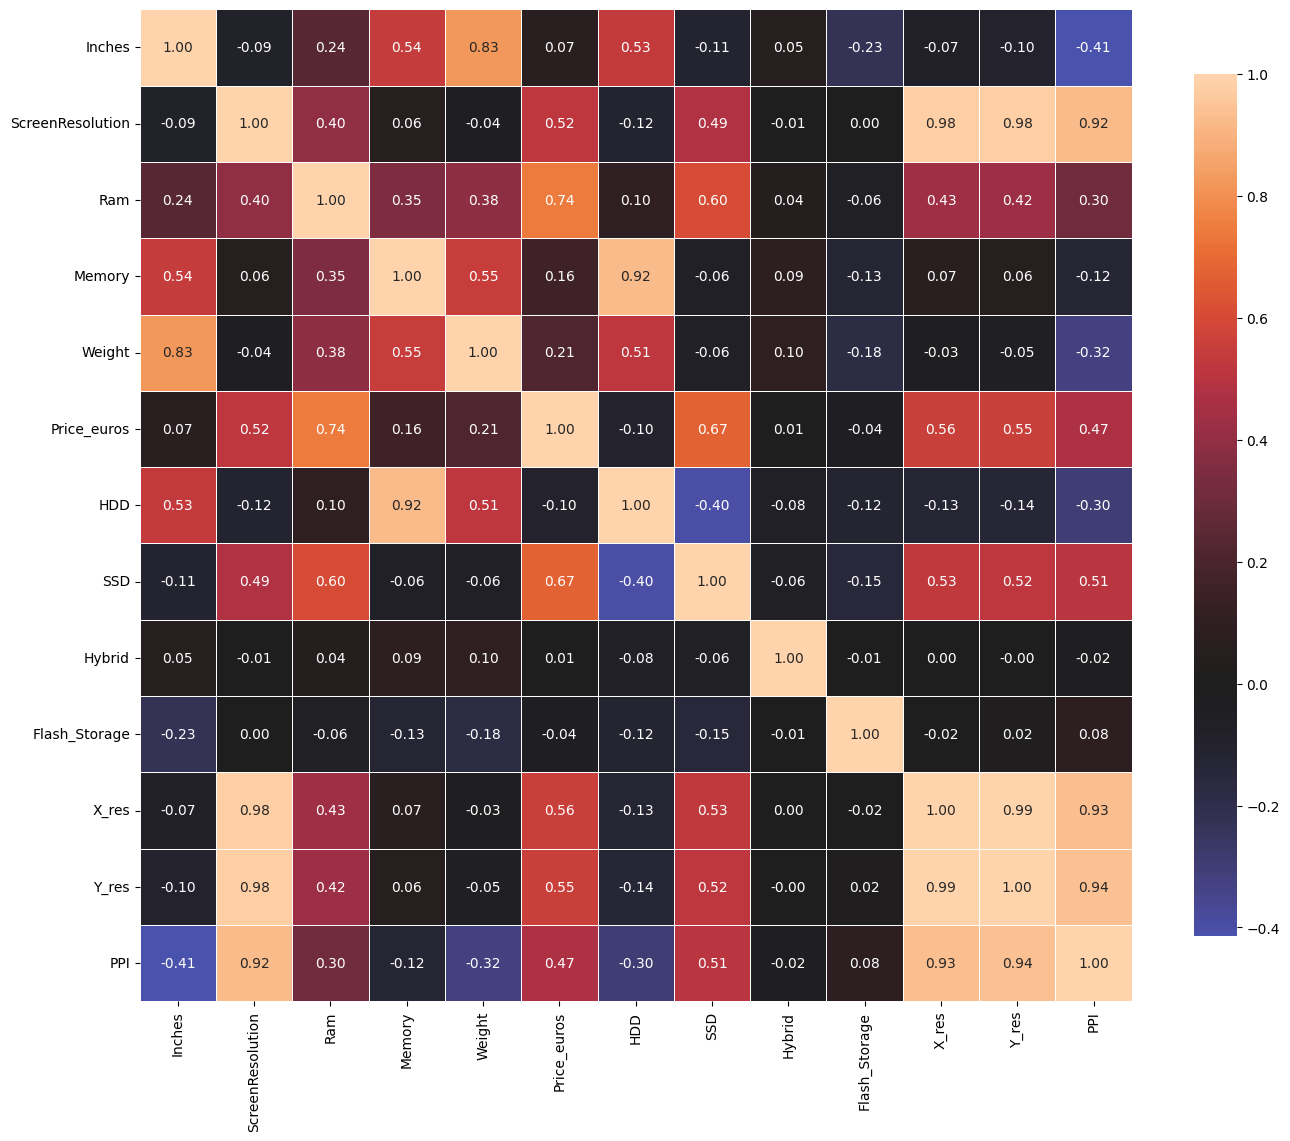

In [9]:
def correlation_heatmap(train):
    correlations = train.corr()
    
    fig, ax = plt.subplots(figsize=(16,16))
    sb.heatmap(correlations, vmax=1.0, center=0, fmt='.2f', square=True, linewidths=.5, annot=True, cbar_kws={"shrink":.70})
    plt.show()
correlation_heatmap(laptops)

<AxesSubplot: xlabel='Price_euros', ylabel='Ram'>

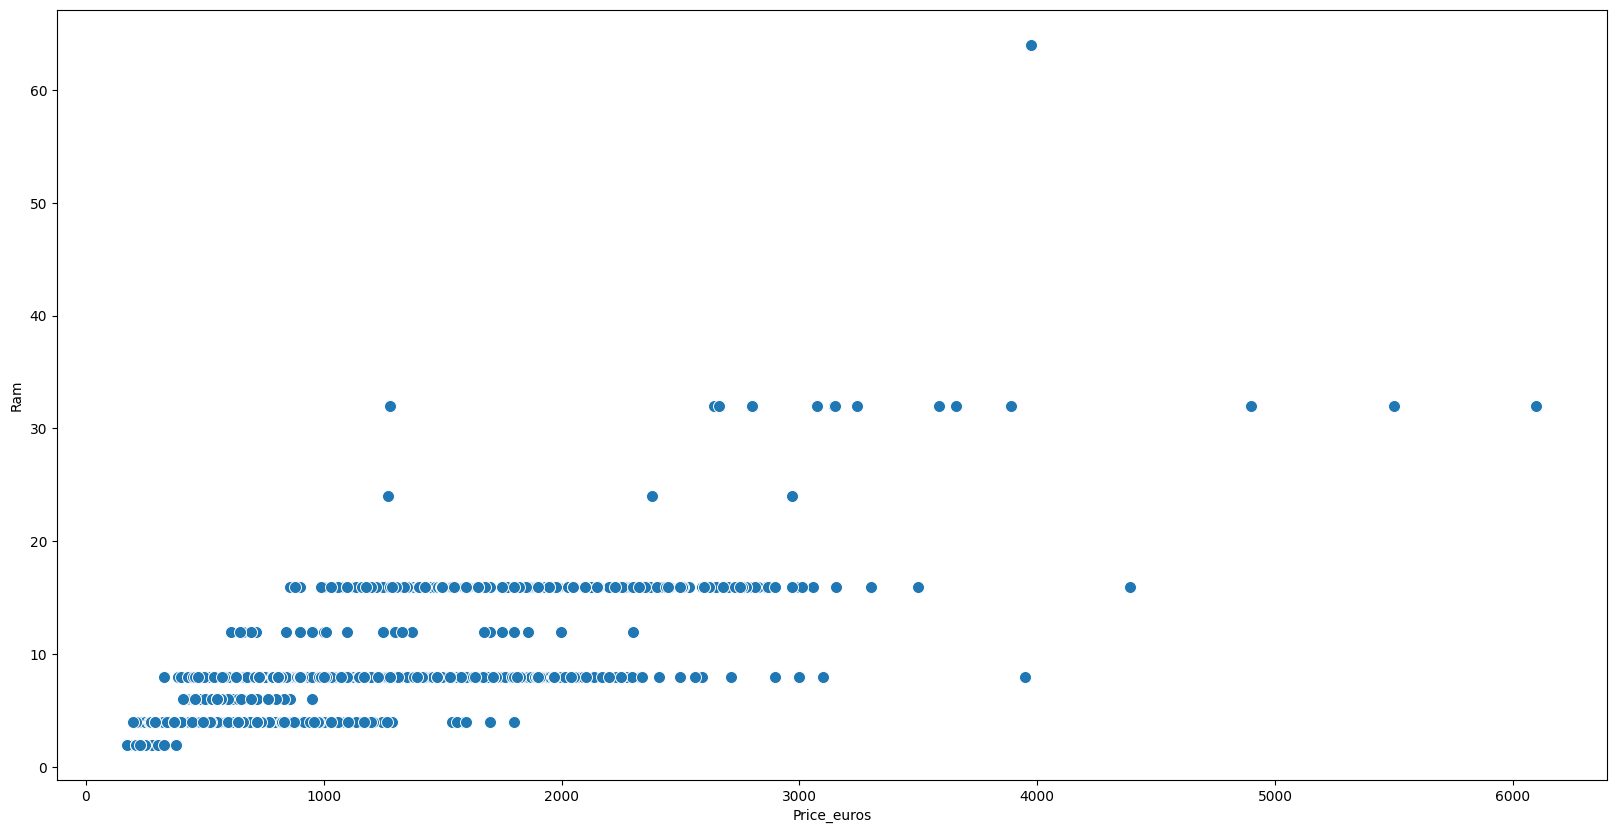

In [10]:
fig_dims = (20, 10)
fig, ax = plt.subplots(figsize=fig_dims)
sb.scatterplot(data=laptops, x="Price_euros", y="Ram", ax=ax, s=75)

<AxesSubplot: xlabel='Price_euros', ylabel='SSD'>

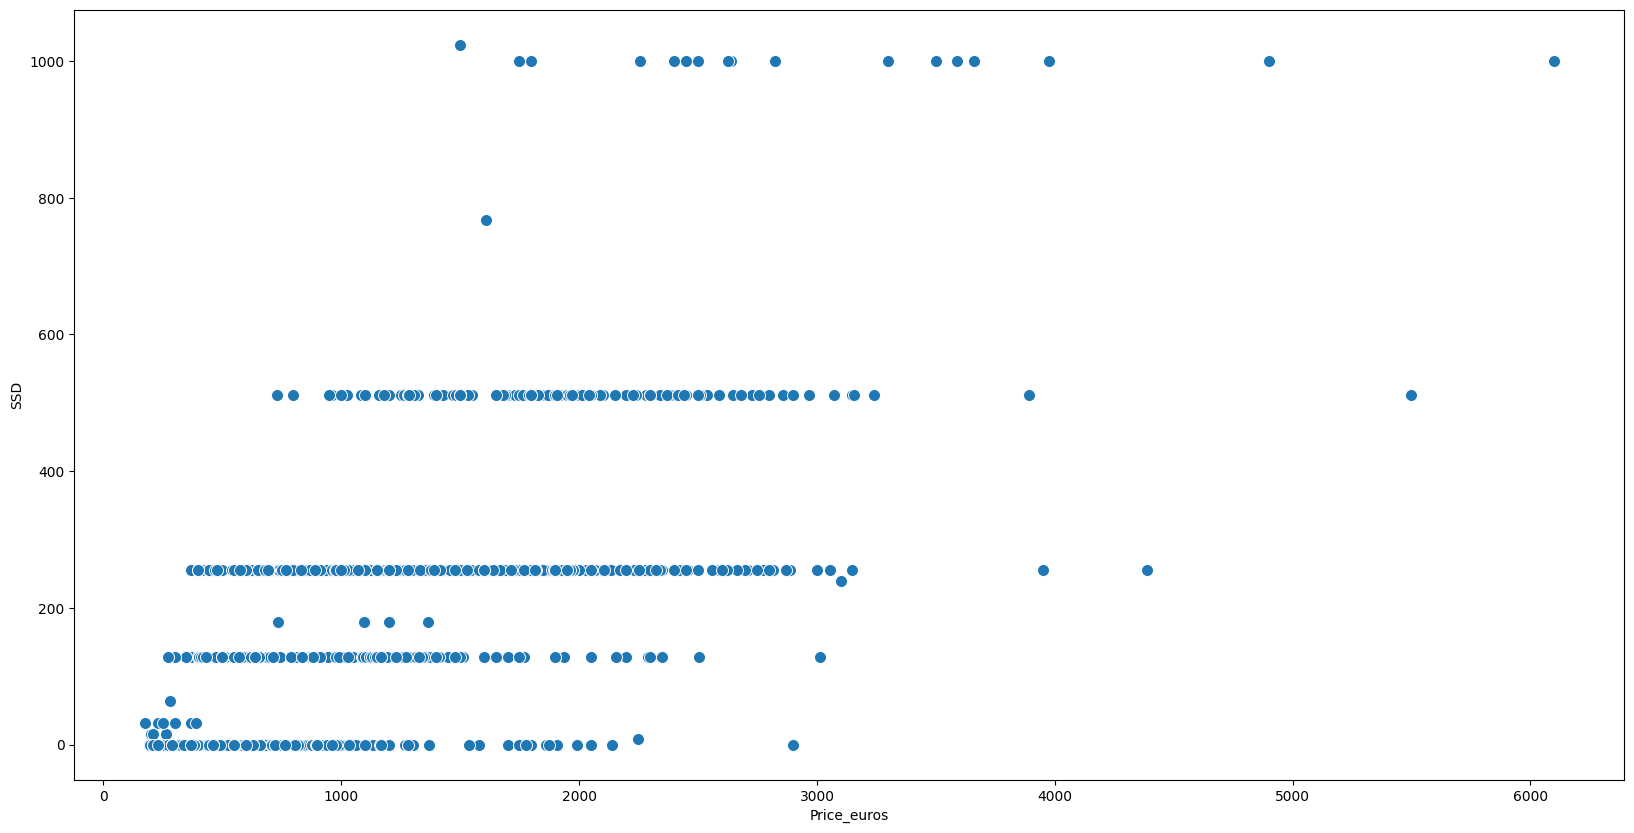

In [11]:
fig_dims = (20, 10)
fig, ax = plt.subplots(figsize=fig_dims)
sb.scatterplot(data=laptops, x="Price_euros", y="SSD", ax=ax, s=75)

## Split Current Data
Now I will split the target feature and from the dataset and sort out the current object features.

In [12]:
X = laptops.drop(['Price_euros'],axis=1)
Y = laptops['Price_euros'].values
X = X.select_dtypes(exclude=['object'])

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=42)

## Train Models
Now I will train a few models and compare them

In [14]:
SGDreg = SGDRegressor()
SGDreg.fit(X_train, y_train)

SGDRegressor()

In [15]:
pred = SGDreg.predict(X_train)
sgd_mse = mean_squared_error(y_train, pred)
sgd_rmse = np.sqrt(sgd_mse)
sgd_rmse

2.2502587055022085e+21

In [16]:
param_grid = {
    'alpha': 10.0 ** -np.arange(1, 7),
    'loss': ['squared_loss', 'huber', 'epsilon_insensitive'],
    'penalty': ['l2', 'l1', 'elasticnet'],
    'learning_rate': ['constant', 'optimal', 'invscaling'],
    'max_iter': [1000, 5000, 10000]
}

grid_search = GridSearchCV(SGDreg, param_grid)
grid_search.fit(X_train, y_train)
print("Best score: " + str(grid_search.best_score_))

c:\Users\dungu.DESKTOP-LH2FL1F\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:165: FutureWarning: The loss 'squared_loss' was deprecated in v1.0 and will be removed in version 1.2. Use `loss='squared_error'` which is equivalent.
  warnings.warn(
c:\Users\dungu.DESKTOP-LH2FL1F\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:165: FutureWarning: The loss 'squared_loss' was deprecated in v1.0 and will be removed in version 1.2. Use `loss='squared_error'` which is equivalent.
  warnings.warn(
c:\Users\dungu.DESKTOP-LH2FL1F\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:165: FutureWarning: The loss 'squared_loss' was deprecated in v1.0 and will be removed in version 1.2. Use `loss='squared_error'` which is equivalent.
  warnings.warn(
c:\Users\dungu.DESKTOP-LH2FL1F\AppData\Local\Programs\Python\Python310\lib\site-packages\sklea

Best score: -74933093.89759012


In [17]:
Kreg = KNeighborsRegressor()
Kreg.fit(X_train, y_train)

KNeighborsRegressor()

In [18]:
pred = Kreg.predict(X_train)
k_mse = mean_squared_error(y_train, pred)
k_rmse = np.sqrt(k_mse)
k_rmse

324.35220050660115

In [19]:
param_grid = {'n_neighbors': np.arange(1, 12, 2),
              'weights': ['uniform', 'distance']}
grid_search = GridSearchCV(Kreg, param_grid)
grid_search.fit(X_train, y_train)
print("Best score: " + str(grid_search.best_score_))

Best score: 0.6442537237995575


In [20]:
final_model = grid_search.best_estimator_
final_pred = final_model.predict(X_test)
final_pred = final_pred.tolist()
for pred in range(0, len(final_pred)):
    print("Predicition: " + str(round(final_pred[pred], 2)) + " Actual: " + str(y_test[pred]))

Predicition: 1277.33 Actual: 1672.0
Predicition: 1235.33 Actual: 1149.0
Predicition: 614.0 Actual: 499.0
Predicition: 1065.67 Actual: 899.0
Predicition: 1614.33 Actual: 1244.0
Predicition: 1474.0 Actual: 1398.99
Predicition: 875.0 Actual: 719.0
Predicition: 469.0 Actual: 459.0
Predicition: 1203.16 Actual: 1191.0
Predicition: 586.67 Actual: 349.0
Predicition: 2289.81 Actual: 1899.0
Predicition: 928.54 Actual: 726.0
Predicition: 1449.0 Actual: 1813.0
Predicition: 483.67 Actual: 805.99
Predicition: 1951.67 Actual: 1949.0
Predicition: 1126.8 Actual: 899.0
Predicition: 1298.0 Actual: 1145.0
Predicition: 928.54 Actual: 961.0
Predicition: 590.67 Actual: 713.07
Predicition: 1641.0 Actual: 1649.0
Predicition: 2605.6 Actual: 2349.0
Predicition: 379.0 Actual: 720.32
Predicition: 885.67 Actual: 798.01
Predicition: 504.76 Actual: 265.0
Predicition: 953.0 Actual: 1149.0
Predicition: 1499.0 Actual: 999.0
Predicition: 682.97 Actual: 959.0
Predicition: 750.33 Actual: 825.0
Predicition: 1664.33 Actual: 

Now let's plot our predicted prices compared to the actual prices.

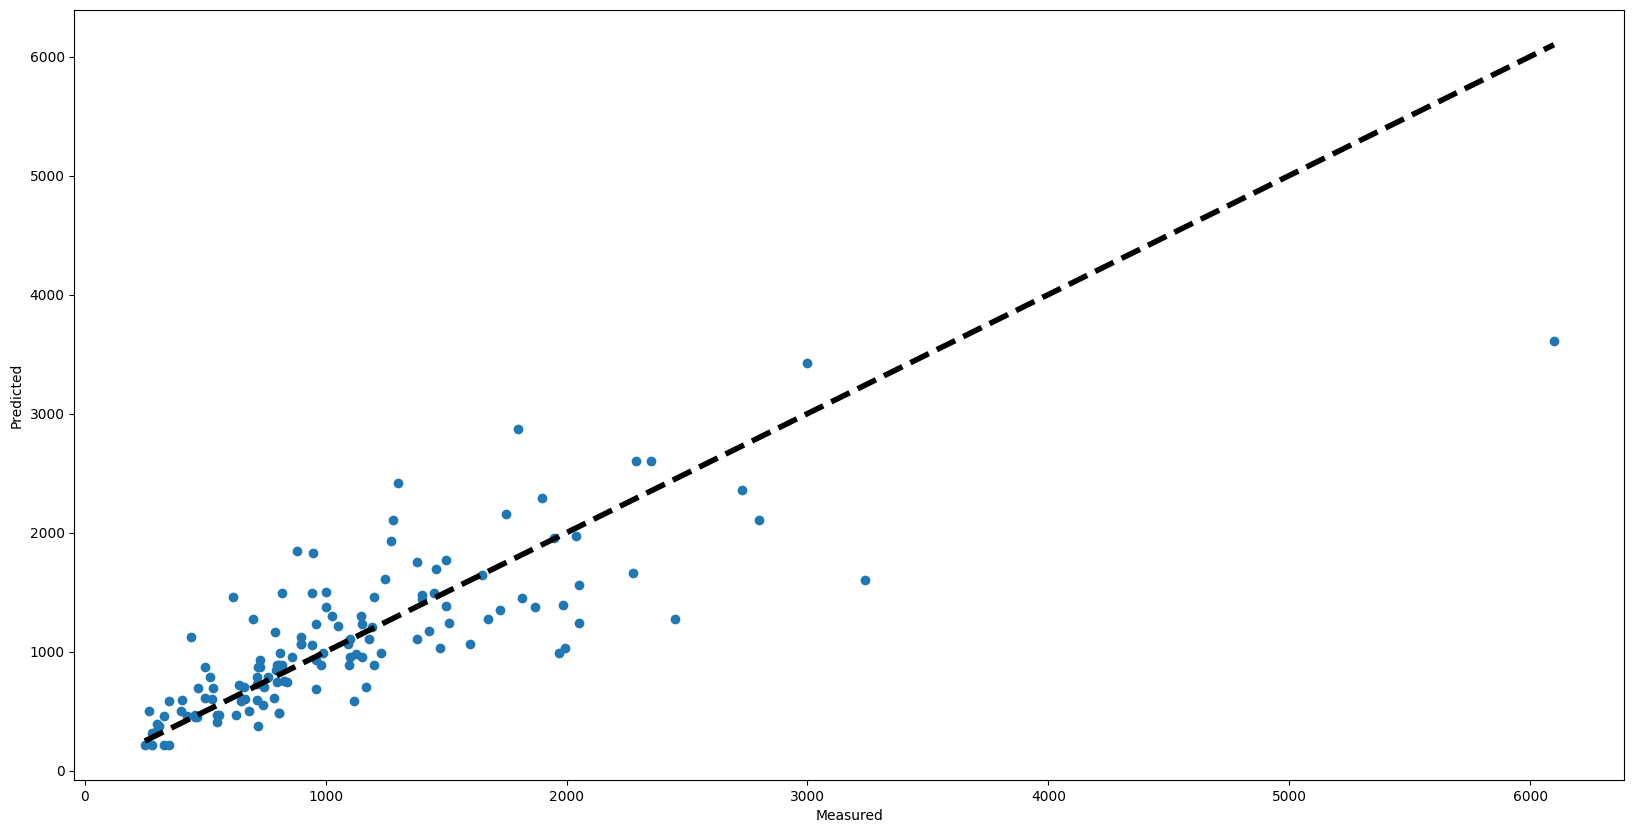

In [21]:
fig_dims = (20, 10)
fig, ax = plt.subplots(figsize=fig_dims)
ax.scatter(y_test, final_pred)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()